In [0]:
# Load neccessary libraries
import tensorflow as tf
from tensorflow import keras
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from keras.applications import vgg16
from keras.preprocessing import image
import cv2
import os                   
import joblib
from pathlib import Path
from PIL import Image

In [0]:
!pip install MTCNN
from mtcnn.mtcnn import MTCNN

In [0]:
#For colab we can upload files by importing google colab files library and upload all required files
from google.colab import files
files.upload()

In [0]:
#now we will unzip the uploaded file
!unzip 5-celebrity-faces-dataset.zip

In [0]:
# Here we make use of vgg16 model you know more about this odel on google
model16 = vgg16.VGG16()                 #this model can categorize 1000 different object
# This model is just to check a sample image. We just need its Weights and structure to train our model which we extract later

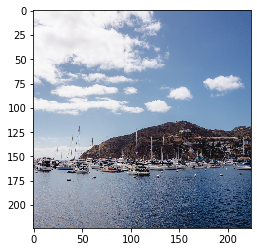

In [0]:
# We will test the model by giving a random image
img = image.load_img("bay.jpg",target_size = (224,224) )
#img = cv2.imread("bay.jpg") ,  img = cv2.resize(img, (224,224)) # If we use openCV library
plt.imshow(img)
plt.show()

In [0]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)               #since we taking a single image
x = vgg16.preprocess_input(x)
predictions = model16.predict(x)
predicted_classes = vgg16.decode_predictions(predictions)
print("Top predictions for this image are : ")
for imagenet_id , name , likelihood in predicted_classes[0] :
  print ("Prediction {} - {:2f}".format(name, likelihood))

40960/35363 [==================================] - 0s 0us/step
Top predictions for this image are : 
Prediction seashore - 0.395213
Prediction promontory - 0.326128
Prediction lakeside - 0.119613
Prediction breakwater - 0.062801
Prediction sandbar - 0.045267


In [0]:
def extract_face(filename, required_size=(64, 64)):
    # load image from file
    image = Image.open(filename)
    # convert to RGB, if needed
    image = image.convert('RGB')
    # convert to array
    pixels = np.asarray(image)
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    # deal with negative pixel index
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    return face_array

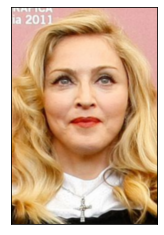



Instructions for updating:
Deprecated in favor of operator or tf.math.divide.



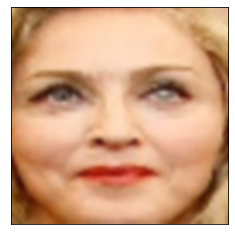

In [0]:
loc = 'data/train/madonna/httpresizeparismatchladmediafrrffffffcentermiddleimgvarnewsstorageimagesparismatchpeopleazmadonnafreFRMadonnajpg.jpg'
img = Image.open(loc)
plt.imshow(img,interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()
face = extract_face(loc)
#face = cv2.imread(face)
plt.imshow(face,interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

In [0]:
# As we can see above we notice that all images are of different size 
X_images = []
for imgfolder in os.listdir("data/train/"):
  for filename in os.listdir("data/train/"+ imgfolder):
    filename = "data/train/" + imgfolder + "/" + filename
    face = extract_face(filename)
    X_images.append(face)
X_images = np.asarray(X_images)
print(X_images.shape)

(93, 64, 64, 3)


In [0]:
#Now lets load output train value and check the shape
y_train = []
names = []
for imgfolder in os.listdir("data/train/"):
  for filename in os.listdir("data/train/"+ imgfolder):
    filename = "data/train/" + imgfolder + "/" + filename
    y_train.append(imgfolder)
  names.append(imgfolder)
y_train = np.asarray(y_train)
print (y_train.shape)
print(names)

(93,)
['madonna', 'jerry_seinfeld', 'elton_john', 'ben_afflek', 'mindy_kaling']


In [0]:
# We will do same for test/val set 
X_test = []
for imgfolder in os.listdir("data/val/"):
  for filename in os.listdir("data/val/"+ imgfolder):
    filename = "data/val/" + imgfolder + "/" + filename
    face = extract_face(filename)
    X_test.append(face)
X_test = np.asarray(X_test)
print("test/val set input shape is ",X_test.shape)

y_test = []
for imgfolder in os.listdir("data/val/"):
  for filename in os.listdir("data/val/"+ imgfolder):
    filename = "data/val/" + imgfolder + "/" + filename
    y_test.append(imgfolder)
y_test = np.asarray(y_test)
print ("test/val set input shape is " ,y_test.shape)

test/val set input shape is  (25, 64, 64, 3)
test/val set input shape is  (25,)


In [0]:
# With these limited data of faces we were not able to achieve the required accuracy
# Now we will do transfer learning to achieve higher accuracy for our faces dataset

# Now we will load our images and Normalize image data to 0-to-1 range
X_train = vgg16.preprocess_input(X_images)
X_test = vgg16.preprocess_input(X_test)

In [0]:
# Output value we change to categorical
from sklearn.preprocessing import LabelEncoder
labenc = LabelEncoder()
y_train = labenc.fit_transform(y_train)
y_test = labenc.fit_transform(y_test)

In [0]:
# Load a pre-trained neural network to use as a feature extractor
pretrained_nn = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Extract features for each image (all in one pass)
features_x = pretrained_nn.predict(X_train)
val_feature = pretrained_nn.predict(X_test)

In [0]:
# We can save our extracted fetures in .dat format 
# This way we can save our training data(array). This does not require us to load heavy image data again and again 
joblib.dump(features_x, "X_train.dat")
joblib.dump(y_train, "y_train.dat")
joblib.dump(val_feature, "X_test.dat")
joblib.dump(y_test,"y_test.dat")         

['y_test.dat']

In [0]:
# We will load back our saved data
X_trainl = joblib.load("X_train.dat")
y_trainl = joblib.load("y_train.dat")
X_testl = joblib.load("X_test.dat")
y_testl = joblib.load("y_test.dat")       

In [0]:
model = tf.keras.models.Sequential([tf.keras.layers.Flatten(input_shape = X_trainl.shape[1:]),
                                    tf.keras.layers.Dense(256,activation='relu'),
                                    tf.keras.layers.Dense(5,activation='softmax')])

In [0]:
# This gives detailed nodes in our network
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               524544    
_________________________________________________________________
dense_17 (Dense)             (None, 5)                 1285      
Total params: 525,829
Trainable params: 525,829
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compile the model
model.compile(optimizer="adam",
              loss = "sparse_categorical_crossentropy",
              metrics = ["accuracy"])

In [0]:
model.fit(X_trainl,y_trainl,epochs=15)
model.evaluate(X_testl,y_testl,verbose=2 )

Train on 93 samples
Epoch 1/15
93/93 [==============================] - 0s 1ms/sample - loss: 18.1543 - acc: 0.3333
Epoch 2/15
93/93 [==============================] - 0s 202us/sample - loss: 4.7864 - acc: 0.7419
Epoch 3/15
93/93 [==============================] - 0s 178us/sample - loss: 0.8545 - acc: 0.8817
Epoch 4/15
93/93 [==============================] - 0s 220us/sample - loss: 1.0208 - acc: 0.9140
Epoch 5/15
93/93 [==============================] - 0s 215us/sample - loss: 0.7325 - acc: 0.9140
Epoch 6/15
93/93 [==============================] - 0s 247us/sample - loss: 0.0444 - acc: 0.9785
Epoch 7/15
93/93 [==============================] - 0s 225us/sample - loss: 6.2186e-04 - acc: 1.0000
Epoch 8/15
93/93 [==============================] - 0s 281us/sample - loss: 3.7561e-04 - acc: 1.0000
Epoch 9/15
93/93 [==============================] - 0s 211us/sample - loss: 0.0087 - acc: 1.0000
Epoch 10/15
93/93 [==============================] - 0s 253us/sample - loss: 0.0021 - acc: 1.0000
Ep

[0.028495876118540764, 1.0]

In [0]:
# Now we will save neural network structure and the trained weights

from pathlib import Path

model_structure = model.to_json()
f = Path("model_structure.json")    #Structure

f.write_text(model_structure)
model.save_weights("model_weights.h5")      #Trained weights